# 0. Import Libraries

In [5]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Images

In [6]:
path_dir = '/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240430/Bare-Segmented image/'
file_list = os.listdir(path_dir)
file_list = [i for i in file_list if i.endswith('.tif')]
file_list = sorted(file_list)
file_list[:5]

['Bare-Segmented imageZ00001.tif',
 'Bare-Segmented imageZ00002.tif',
 'Bare-Segmented imageZ00003.tif',
 'Bare-Segmented imageZ00004.tif',
 'Bare-Segmented imageZ00005.tif']

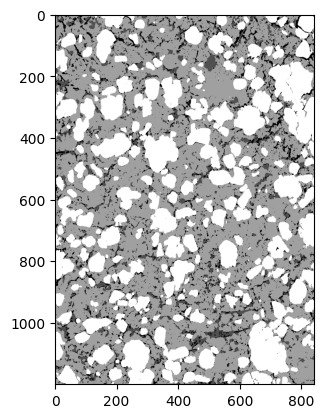

In [7]:
plt.imshow(cv.imread(path_dir + file_list[0]))

In [8]:
img_l = []
for i in file_list:
    img = cv.imread(path_dir + i)
    img_l.append(img)

# 2. Extract Contours of Cathodes

In [17]:
font = cv.FONT_HERSHEY_SIMPLEX
def contour(image, th, count, trys):
    black = cv.imread('/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240425/black.jpg')
    image1 = image.copy()
    img_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    kernel = np.ones((10,10), np.uint8)
    ret, img_binary = cv.threshold(img_gray, th ,255, 0)
    opening = cv.morphologyEx(img_binary,cv.MORPH_OPEN,kernel,iterations=0)
    mode = cv.RETR_EXTERNAL 
    contours, hierarchy = cv.findContours(opening, mode, cv.CHAIN_APPROX_NONE) 
    i = 0
    filtered_contours = []
    for cnt in contours: 
        if len(cnt) > 30:        
            if (cnt[:,:,0].reshape(1,-1).tolist()[0].count(0)>=5):
                cv.drawContours(black, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
                pas = 1
            elif (cnt[:,:,0].reshape(1,-1).tolist()[0].count(839) >= 5) :
                cv.drawContours(black, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
                pas = 1
            elif (cnt[:,:,1].reshape(1,-1).tolist()[0].count(0) >=5) :
                cv.drawContours(black, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
                pas = 1
            elif (cnt[:,:,1].reshape(1,-1).tolist()[0].count(1199) >=5) : 
                cv.drawContours(black, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
                pas = 1

            else: 
                cv.drawContours(black, cnt, -1, (0, 0, 255), 2, cv.LINE_4) 
                M = cv.moments(cnt)
                if M['m00'] == 0:
                    M['m00'] = 0.0001
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                cv.putText(black, str(i), (cx, cy), font, 0.5, (0, 255, 0), 2 )
                filtered_contours.append(cnt)
                i = i+1

    if trys == 1:
        plt.figure(figsize = (20,8))
        plt.imshow(black)
        plt.show()

    d = pd.DataFrame({})
    filtered_cont_target = [contour_target.tolist() for contour_target in filtered_contours]
    d['ncm'] = filtered_cont_target  
    count = count + 1

    return image, contours, filtered_contours


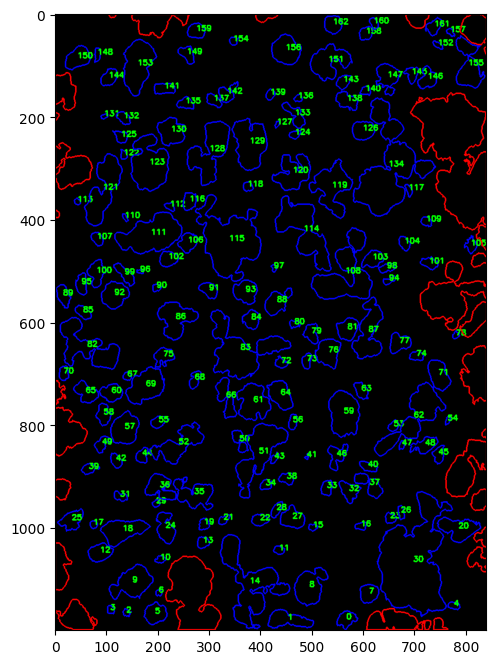

In [18]:
count = 0
x,y,z, u  = [],[], [], []
for i in file_list:
    img = cv.imread(path_dir + i)
    img_test, contours, filtered_contours = contour(img, 200, count, count)
    x = x + filtered_contours[0][:,:,0].reshape(1,-1).tolist()[0]
    y = y + filtered_contours[0][:,:,1].reshape(1,-1).tolist()[0]
    z = z + [count]*len(filtered_contours[0][:,:,1].reshape(1,-1).tolist()[0])
    count = count + 1


# 3. Extract Contours of Pores and Filtering NCM-adjacent Pores

In [21]:
def inv_contour(image, th, tries):
    image1 = image.copy()
    img_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    img_gray = 255-img_gray
    
    kernel = np.ones((10,10), np.uint8)
    ret, img_binary = cv.threshold(img_gray, th ,255, 0)
    opening = cv.morphologyEx(img_binary,cv.MORPH_OPEN,kernel,iterations=0)
    mode = cv.RETR_EXTERNAL 
    contours, hierarchy = cv.findContours(opening, mode, cv.CHAIN_APPROX_NONE) 
    i = 0
    filtered_contours = []
    for cnt in contours: 
        if len(cnt) > 25:        
            if (cnt[:,:,0].reshape(1,-1).tolist()[0].count(0)>=3):
                cv.drawContours(image1, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
            elif (cnt[:,:,0].reshape(1,-1).tolist()[0].count(839) >= 3) :
                cv.drawContours(image1, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
            elif (cnt[:,:,1].reshape(1,-1).tolist()[0].count(0) >=3) :
                cv.drawContours(image1, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 
            elif (cnt[:,:,1].reshape(1,-1).tolist()[0].count(1199) >=3) : 
                cv.drawContours(image1, cnt, -1, (255, 0, 0), 2, cv.LINE_4) 

            else: 
                cv.drawContours(image1, cnt, -1, (0, 0, 255), 2, cv.LINE_4) 
                filtered_contours.append(cnt)            
    if tries == 1:
        plt.figure(figsize = (20,8))
        plt.imshow(image1)
        plt.show()   
    return image, contours, filtered_contours

In [22]:
def window(image, filtered_contours):
    image1 = image.copy()
    img_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    tot_tar_cordi = []
    for i in filtered_contours:
        target = i.reshape(len(i),2)
        tar_cordi_list = []
        for j in target:
            x, y = j[0], j[1]
            
            start_point = [x-1, y-1]
            end_point = [x+1, y+1]

            cv.rectangle(image1, start_point, end_point, (0,255,0), 3)
            
            pos = np.array([[x-1, y-1], [x, y-1], [x+1, y-1], 
                   [x-1, y], [x, y], [x+1, y], 
                   [x-1, y+1], [x, y+1], [x+1, y+1]])
            
            tar_img = img_gray[y-1:y+2, x-1:x+2]
            tar_shape = tar_img.shape
            tar_label = np.where(tar_img.reshape(tar_shape[0]*tar_shape[1],) == 0)
            tar_cordi = pos[tar_label[0]]   
            
            if len(tar_cordi) != 0: 
                for k in tar_cordi:
                    tar_cordi_list.append(k)
            
        tot_tar_cordi.append(tar_cordi_list)
        
    return tot_tar_cordi

In [24]:
a, b, c = inv_contour(img, 250, 0)

In [25]:
zero_cordi = window(img, filtered_contours)
adj_cont = []
for i in zero_cordi[0]:
    for k in c: 
        if ([i[0]] in k[:,:,0].tolist()) and ([i[1]] in k[:,:,1].tolist()):
            adj_cont.append(k)

# 4. Combine Codes

In [31]:
path_dir = '/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240430/Bare-Segmented image/'
file_list = os.listdir(path_dir)
file_list = [i for i in file_list if i.endswith('.tif')]
file_list = sorted(file_list)

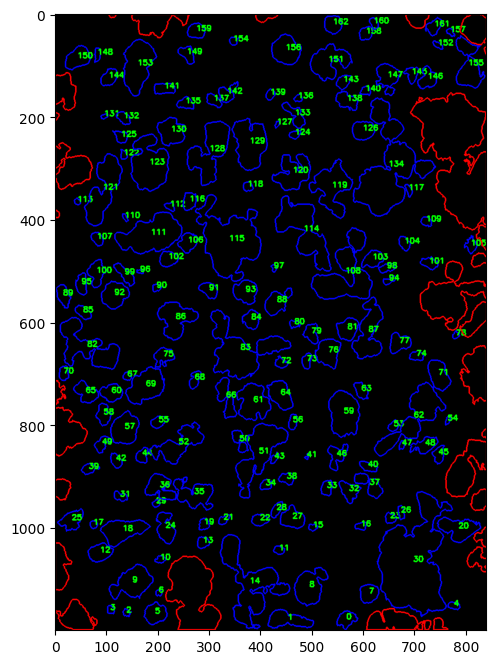

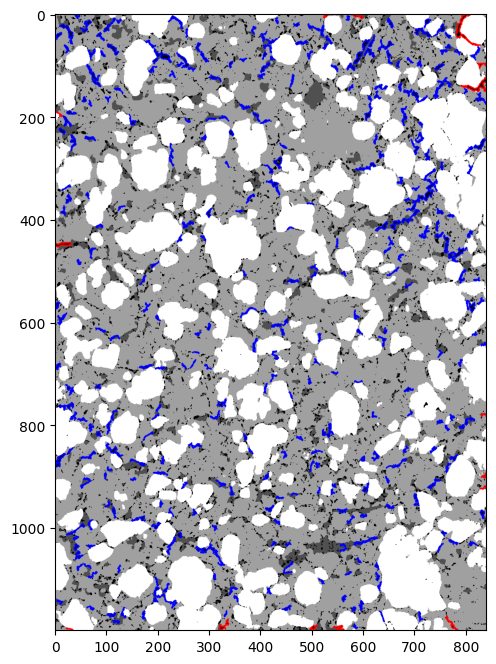

In [30]:
count = 0
for file in file_list[:2]:
    img = cv.imread(path_dir + file)
    img_test, contours, filtered_contours = contour(img, 200, count, count)
    a, b, c = inv_contour(img, 250, count)
    zero_cordi = window(img, filtered_contours)

    d = pd.DataFrame({})
    pore_list = []
    for n in range(len(zero_cordi)):
        p_list = []
        for i in zero_cordi[n] : 
            adj_cont = []
            for k in c: 
                if ([i[0]] in k[:,:,0].tolist()) and ([i[1]] in k[:,:,1].tolist()):
                    adj_cont.append( k[:,0].tolist()) 

                    cv.drawContours(img, k, -1, (0, 0, 255), 2, cv.LINE_4) 
            if adj_cont not in p_list:
                p_list.append(adj_cont)

        pore_list.append(p_list)


    d = pd.DataFrame({})
    filtered_cont_target = [contour_target.tolist() for contour_target in filtered_contours]
    d['ncm'] = filtered_cont_target 
    d['pore'] = pore_list
    d.to_csv('/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240430/ncmwithpore_csv/bare/' + str(count) + '.csv')
    count += 1